In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


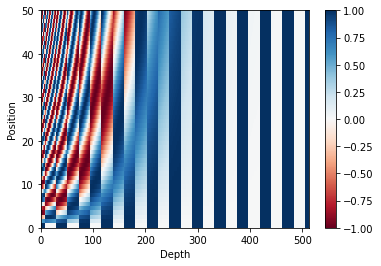

In [3]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [3]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

In [5]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [7]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [6]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [9]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [10]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [7]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [8]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [9]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [10]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [18]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin='http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,'movie_conversations.txt')

9928704/9916637 [==============================] - 1s 0us/step


In [19]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 100000
print(MAX_SAMPLES)

100000


In [20]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [21]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
  id2line = {}
  with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

  inputs, outputs = [], []
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()

  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]

    for i in range(len(conversation) - 1):
      # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
      inputs.append(preprocess_sentence(id2line[conversation[i]]))
      outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))

      if len(inputs) >= MAX_SAMPLES:
        return inputs, outputs
  return inputs, outputs

In [22]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 100000
전체 샘플 수 : 100000


In [23]:
type(questions)

list

In [20]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: she s not a . . .
전처리 후의 22번째 답변 샘플: lesbian ? no . i found a picture of jared leto in one of her drawers , so i m pretty sure she s not harboring same sex tendencies .


In [22]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [23]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [24]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8171]
END_TOKEN의 번호 : [8172]


In [25]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8173


In [26]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [57, 8, 36, 8012, 44]
정수 인코딩 후의 21번째 답변 샘플: [1376, 6244, 20, 58, 3, 4, 351, 10, 1273, 15, 1144, 750, 1901, 271, 16, 69, 15, 98, 2086, 733, 2, 61, 4, 24, 337, 202, 57, 8, 36, 1076, 3022, 7947, 336, 1133, 5935, 4562, 309, 1]


In [57]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 20
print(MAX_LENGTH)

20


In [30]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [31]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8173
필터링 후의 질문 샘플 개수: 87766
필터링 후의 답변 샘플 개수: 87766


In [33]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [34]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [35]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3146496     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [36]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [37]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

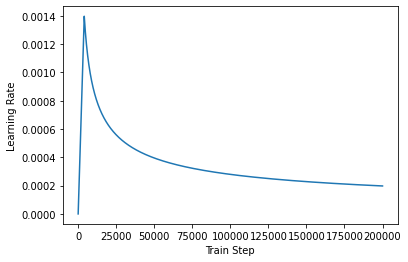

In [38]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [39]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [40]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
1372/1372 [==============================] - 88s 54ms/step - loss: 1.8331 - accuracy: 0.0606
Epoch 2/20
1372/1372 [==============================] - 74s 54ms/step - loss: 1.4110 - accuracy: 0.0869
Epoch 3/20
1372/1372 [==============================] - 74s 54ms/step - loss: 1.3417 - accuracy: 0.0920
Epoch 4/20
1372/1372 [==============================] - 74s 54ms/step - loss: 1.2843 - accuracy: 0.0962
Epoch 5/20
1372/1372 [==============================] - 74s 54ms/step - loss: 1.2306 - accuracy: 0.1001
Epoch 6/20
1372/1372 [==============================] - 74s 54ms/step - loss: 1.1882 - accuracy: 0.1034
Epoch 7/20
1372/1372 [==============================] - 74s 54ms/step - loss: 1.1531 - accuracy: 0.1065
Epoch 8/20
1372/1372 [==============================] - 74s 54ms/step - loss: 1.1234 - accuracy: 0.1092
Epoch 9/20
1372/1372 [==============================] - 74s 54ms/step - loss: 1.0967 - accuracy: 0.1118
Epoch 10/20
1372/1372 [==============================] - 74s 54m

In [41]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [42]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [43]:
sentence_generation('Where have you been?')

입력 : Where have you been?
출력 : i don t know . i don t know . i just don t know .


'i don t know . i don t know . i just don t know .'

In [44]:
sentence_generation("It's a trap")

입력 : It's a trap
출력 : i m not sure that s the way you re doing this to the movies .


'i m not sure that s the way you re doing this to the movies .'

## 여기서 부터 실습!
### Step 1. 데이터 수집하기

In [2]:
! mkdir -p ~/aiffel/transformer_chatbot/data/

In [3]:
! ln -s ~/data/* ~/aiffel/transformer_chatbot/data/

ln: failed to create symbolic link '/aiffel/aiffel/transformer_chatbot/data/ChatbotData .csv': File exists


### Step 2. 데이터 전처리하기

#### 2-1) 데이터 가져오기

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

In [11]:
path_to_zip=os.getenv('HOME')+'/aiffel/transformer_chatbot/data/ChatbotData .csv' # 기본데이터에 공백 뭐냐구

In [12]:
import pandas as pd

In [13]:
df = pd.read_csv(path_to_zip)

In [14]:
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [15]:
datasetQ = df['Q'] #파일로 되있는거 아니니까 분리하는 함수 안써도 될듯
datasetA = df['A']

In [16]:
print(datasetQ[100])
print(datasetA[100])

거지됐어
밥 사줄 친구를 찾아 보세요~


In [17]:
len(df)           # 표본이 적어서 딱히 추출은 안해도 괜찮을꺼 같다.

11823

In [18]:
df.isnull().sum() # 결측치도 없음

Q        0
A        0
label    0
dtype: int64

#### 2-2) 전처리 함수 만들기

In [19]:
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  #단어, 온점사이 거리 한칸띄우기
  sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣?.!,]+", " ", sentence)
  #모든 한글, 자음, 모음 ?.!, 제외 전부 공백으로 만들기
  sentence = re.sub(r'[" "]+', " ", sentence)
  #2칸 이상 공백 한칸으로 만들기
  sentence = sentence.strip()
  #좌우 공백 없애기
  return sentence

각종 자음과 모음을 없애는게 맞나 안없애는게 맞나 고민이 되지만, '챗'에서는 각종 자음 모음(ㅋㅋㅋ 등)이 의미를 가지는 점을 생각해
안 없애도록 했다.  

ㅋ의 개수등 의성어 등에서 같은 글자 반복의 의미도... 나름 뉘앙스를 살리기 위해 그대로 두려고 한다.

이모티콘 등도 고민해봤는데... 음 어차피 데이터에 그런 자음 모음이나 이모티콘이 하나도 없어서 상관없을 듯

In [20]:
questions = [preprocess_sentence(i) for i in datasetQ]

In [21]:
print(questions[1])

지망 학교 떨어졌어


In [22]:
answers = [preprocess_sentence(i) for i in datasetA]

In [35]:
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [37]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


### Step 3. SubwordTextEncoder 사용하기
#### 3-1) 단어장 만들기

In [39]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
# 단어장 크기가 얼추 8000개인데 일단 진행해보자

In [40]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [41]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8135]
END_TOKEN의 번호 : [8136]


In [42]:
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8137


#### 3-2) 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

In [43]:
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5747, 612, 2485, 4153]
정수 인코딩 후의 21번째 답변 샘플: [2353, 7489, 7, 6252, 97, 1]


In [49]:
df.describe() # 정수가 아니라 안된다.

,label
count,11823.000000
mean,0.803180
std,0.812012
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


In [53]:
length_Q = [len(i) for i in questions]
length_A = [len(i) for i in answers]
print(np.mean(length_Q), np.mean(length_A))

13.180749386788463 16.02630466040768


In [56]:
print(np.max(length_Q), np.max(length_A))

57 78


In [58]:
print(np.std(length_Q), np.std(length_A))

6.40096902923874 6.777032944184938


In [59]:
MAX_LENGTH = 30     #2표준편차 정도만 하자
print(MAX_LENGTH)

30


In [60]:
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 30 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 30으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH)
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH)
  
  return tokenized_inputs, tokenized_outputs

In [61]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8137
필터링 후의 질문 샘플 개수: 11822
필터링 후의 답변 샘플 개수: 11822


#### 3-3) 교사 강요(Teacher Forcing) 사용하기

In [205]:
BATCH_SIZE = 64
BUFFER_SIZE = 12000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


TypeError: list indices must be integers or slices, not tuple

### Step 4. 모델 구성하기
#### 4-1) 트랜스포머 함수 구성하기

In [48]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

#### 4-2) 모델 생성

In [76]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3137280     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

#### 4-3) 손실 함수(Loss function)

In [49]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

#### 4-4) 커스텀된 학습률

In [50]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

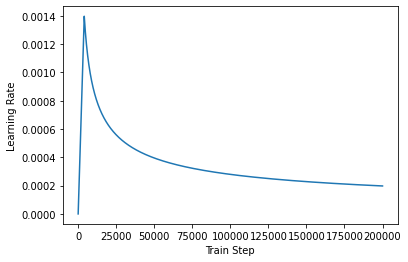

In [79]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

#### 4-5) 모델 컴파일

In [55]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

#### 4-6) 훈련하기

In [81]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 22s 45ms/step - loss: 2.1884 - accuracy: 0.0616
Epoch 2/20
185/185 [==============================] - 8s 46ms/step - loss: 1.6784 - accuracy: 0.1010
Epoch 3/20
185/185 [==============================] - 8s 45ms/step - loss: 1.3312 - accuracy: 0.1045
Epoch 4/20
185/185 [==============================] - 8s 45ms/step - loss: 1.2094 - accuracy: 0.1103
Epoch 5/20
185/185 [==============================] - 8s 45ms/step - loss: 1.1256 - accuracy: 0.1154
Epoch 6/20
185/185 [==============================] - 8s 45ms/step - loss: 1.0425 - accuracy: 0.1213
Epoch 7/20
185/185 [==============================] - 8s 45ms/step - loss: 0.9539 - accuracy: 0.1300
Epoch 8/20
185/185 [==============================] - 8s 45ms/step - loss: 0.8580 - accuracy: 0.1409
Epoch 9/20
185/185 [==============================] - 8s 45ms/step - loss: 0.7556 - accuracy: 0.1532
Epoch 10/20
185/185 [==============================] - 8s 46ms/step - loss: 0.6488 - accur

### Step 5. 모델 평가하기

In [83]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [84]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [85]:
sentence_generation('졸리다')

입력 : 졸리다
출력 : 그 분 생각에 잠을 설쳤나봐요 . 시간을 가져요 . 설계기를 살펴보면 서로션��진 않나봐요 .


'그 분 생각에 잠을 설쳤나봐요 . 시간을 가져요 . 설계기를 살펴보면 서로션��진 않나봐요 .'

In [86]:
sentence_generation('신나')

입력 : 신나
출력 : 자연의 의하지 않으면 요 . 시간을 가져요 . 예를들면 운동이나 여행같이 잡념을 없앨 거예요 . 거예요 .


'자연의 의하지 않으면 요 . 시간을 가져요 . 예를들면 운동이나 여행같이 잡념을 없앨 거예요 . 거예요 .'

In [87]:
sentence_generation('배고파')

입력 : 배고파
출력 : 얼른 맛난 음식 드세요


'얼른 맛난 음식 드세요'

In [88]:
sentence_generation('좋은 노래 추천해줘')

입력 : 좋은 노래 추천해줘
출력 : 이김에 떠나보세요 . 시간을 가지고 있네요 . 그래도 보고 부딪히지도 않아서 제대로 된 연애가 가능하지 않을 수도 있어요 . 새로운 인연이 있기 마요 .


'이김에 떠나보세요 . 시간을 가지고 있네요 . 그래도 보고 부딪히지도 않아서 제대로 된 연애가 가능하지 않을 수도 있어요 . 새로운 인연이 있기 마요 .'

In [89]:
sentence_generation('뭐 하고 있어?')

입력 : 뭐 하고 있어?
출력 : 지금 당장 내일 일도 보가 부족한 걸 수도 있어요 . 그래도 좋아하는 건 어떨까요 . 그때 보고 맛있는 거 같아요 . 새로운 모습을 봤나봐요 .


'지금 당장 내일 일도 보가 부족한 걸 수도 있어요 . 그래도 좋아하는 건 어떨까요 . 그때 보고 맛있는 거 같아요 . 새로운 모습을 봤나봐요 .'

~~시간 탐험대인가?~~ 일단 Loss대비 Accuracy가 낮은건 언어라는 특성대비 어쩔 수 없다고 생각한다.
나름대로 적절한 대답을 하는 것으로 보이지만, 문법에 맞지 않는 문장을 출력하는 경우도 있고
잘 모르는 문장에 대해서는 연애와 관련된 대화를 일단 출력하는 듯 하다.

데이터상 감정과 관련된 대화가 많았으니 어쩔 수 없다고 생각은 하지만, 아마 형태소 분석기를 사용하면
문법과 관련된 부분에서는 더 나은 결과를 낼 수 있지 않을까 한다.

### Step 6. 형태소 분석 토크나이저 사용

In [23]:
from konlpy.tag import Mecab
from collections import Counter

In [24]:
tokenizer = Mecab()

In [25]:
print(questions[1])

지망 학교 떨어졌어


In [118]:
tmp = []
tmp = tokenizer.morphs(questions[0])

print(tmp)

['시', '땡', '!']


In [106]:
dir(Mecab())

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'dicpath',
 'morphs',
 'nouns',
 'pos',
 'tagger',
 'tagset']

In [26]:
tokens = []
for i in (questions+answers):
    tokens += tokenizer.morphs(i)

In [27]:
print(len(tokens))
print(tokens[:30])

181611
['시', '땡', '!', '지망', '학교', '떨어졌', '어', '박', '일', '놀', '러', '가', '고', '싶', '다', '박', '일', '정도', '놀', '러', '가', '고', '싶', '다', '심하', '네', '카드', '망가졌', '어', '카드']


#### 인코딩, 패딩, 단어장 크기 등등 SubwordTextEncoder에서 자동으로 해주는 기능을 수동으로 넣어야 할꺼같다.

In [28]:
tokens_set = set(tokens)

In [29]:
tokens = list(tokens_set) #중복 리스트 삭제

In [30]:
len(tokens)

6796

In [31]:
tokens = ['<패딩>'] + tokens

In [187]:
tokens[:10]

['<패딩>', '남자', '그럴까', '반응', '흑기사', '찾아다니', '외비', '취한', '차례', '팀']

In [32]:
word_to_index = {word:index for index, word in enumerate(tokens)}

In [33]:
word_to_index

{'<패딩>': 0,
 '멈출': 1,
 '쌍': 2,
 '걸려요': 3,
 '한다면': 4,
 '프로필': 5,
 '위': 6,
 '추': 7,
 '상사': 8,
 '친근': 9,
 '헤아려도': 10,
 '현명': 11,
 '주일': 12,
 '해졌': 13,
 '공급': 14,
 '기다린다는': 15,
 '인턴': 16,
 '양면': 17,
 '오르': 18,
 '떠날까': 19,
 '생선': 20,
 '발달': 21,
 '억울': 22,
 '취직': 23,
 '때문': 24,
 '가까이': 25,
 '반려자': 26,
 '어떻': 27,
 '둘': 28,
 '불러줄게요': 29,
 '터리': 30,
 '인지': 31,
 '학원': 32,
 '상태': 33,
 '외국': 34,
 '지금': 35,
 '막': 36,
 '잤': 37,
 '멀쩡': 38,
 '달라': 39,
 '볶': 40,
 '끗': 41,
 '길러': 42,
 '살펴봐요': 43,
 '퍼가': 44,
 '나아졌': 45,
 '탄생': 46,
 '쏜': 47,
 '너': 48,
 '야이': 49,
 '다가왔': 50,
 '보여요': 51,
 '미련': 52,
 '폼': 53,
 '국밥': 54,
 '없애': 55,
 '무너짐': 56,
 '누나': 57,
 '앞둔': 58,
 '어울릴': 59,
 '식초': 60,
 '권태기': 61,
 '난감': 62,
 '과거': 63,
 '수학': 64,
 '연상녀': 65,
 '기도': 66,
 '헹궈': 67,
 '모른': 68,
 '놀러와': 69,
 '달려왔': 70,
 '일단': 71,
 '옳소': 72,
 '에서': 73,
 '기울이': 74,
 '들이': 75,
 '코코넛': 76,
 '자랑': 77,
 '강요': 78,
 '목록': 79,
 '감정': 80,
 '해줘서': 81,
 '이어': 82,
 '느라고': 83,
 '느껴진다': 84,
 '준다는': 85,
 '아래': 86,
 '급기': 87,
 '비극': 88,
 '으신': 8

In [34]:
len(word_to_index)

6797

In [35]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [36]:
index_to_word[6797]='<시작>'
index_to_word[6798]='<끝>'
index_to_word[6799]='<몰?루>'

In [37]:
word_to_index = {index:word for word, index in index_to_word.items()} 

In [84]:
def get_encoded_sentence(sentence, word_to_index):
#    return [word_to_index['<시작>']+word_to_index[word]+ word_to_index['<끝>'] if word in word_to_index else word_to_index['<몰?루>'] for word in sentence.split()]
    arr = [word_to_index[word] if word in word_to_index else word_to_index['<몰?루>'] for word in sentence.split()]
    return arr 

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<몰?루>' for index in encoded_sentence[1:-1])  #[1:-1]를 통해 시작, 끝 토큰을 제외

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [39]:
def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] if word in word_to_index else word_to_index['<몰?루>'] for word in wordlist]

In [40]:
question_t = list(map(wordlist_to_indexlist, questions))
answer_t = list(map(wordlist_to_indexlist, answers))

In [41]:
question_t[1]

[1073, 5721, 6799, 925, 6799, 6799, 4005, 3189, 1643, 3189]

In [42]:
question_tp = tf.keras.preprocessing.sequence.pad_sequences(question_t,
                                                        value = word_to_index["<패딩>"],
                                                        maxlen = 20)

answers_tp = tf.keras.preprocessing.sequence.pad_sequences(answer_t,
                                                       value = word_to_index['<패딩>'],
                                                       maxlen = 20)

In [43]:
question_tp[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 1073,
       5721, 6799,  925, 6799, 6799, 4005, 3189, 1643, 3189], dtype=int32)

In [239]:
tokens[0]

'<패딩>'

In [240]:
word_to_index["<패딩>"]

0

In [44]:
VOCAB_SIZE = len(tokens)+3

In [45]:
print(VOCAB_SIZE)

6800


In [46]:
BATCH_SIZE = 64
BUFFER_SIZE = 12000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': question_tp,
        'dec_inputs': answers_tp[:, :-1]
    },
    {
        'outputs': answers_tp[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [51]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    2795008     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [59]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [60]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 12s 35ms/step - loss: 5.7695 - accuracy: 0.1676
Epoch 2/20
185/185 [==============================] - 6s 34ms/step - loss: 3.5487 - accuracy: 0.2642
Epoch 3/20
185/185 [==============================] - 6s 34ms/step - loss: 2.4541 - accuracy: 0.3376
Epoch 4/20
185/185 [==============================] - 6s 34ms/step - loss: 2.0401 - accuracy: 0.3791
Epoch 5/20
185/185 [==============================] - 6s 34ms/step - loss: 1.7916 - accuracy: 0.4089
Epoch 6/20
185/185 [==============================] - 6s 35ms/step - loss: 1.6233 - accuracy: 0.4321
Epoch 7/20
185/185 [==============================] - 6s 35ms/step - loss: 1.4715 - accuracy: 0.4542
Epoch 8/20
185/185 [==============================] - 6s 34ms/step - loss: 1.3446 - accuracy: 0.4738
Epoch 9/20
185/185 [==============================] - 6s 35ms/step - loss: 1.2456 - accuracy: 0.4891
Epoch 10/20
185/185 [==============================] - 6s 35ms/step - loss: 1.1618 - accur

In [92]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(START_TOKEN + get_encoded_sentence(sentence, word_to_index) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [ ]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [97]:
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<몰?루>' for index in encoded_sentence[1:])

In [120]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)
    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = prediction.tolist()
    
    
    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [140]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  prediction = prediction.numpy()
  prediction = prediction.tolist()
  predicted_sentence = ' '.join(index_to_word[index] if index in index_to_word else '<몰?루>' for index in prediction[1:-1])
  predicted_sentence = re.sub(r"\s+", "", predicted_sentence)
  predicted_sentence = re.sub(r"\<몰\?루\>", " ", predicted_sentence)
  predicted_sentence = predicted_sentence.strip()

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [127]:
sentence_generation('뭐 하고 있어?')

입력 : 뭐 하고 있어?
출력 : <몰?루> 없 다 면 <몰?루> 정 리 해 서 <몰?루> 확 실 히 <몰?루> 하 세 요 <몰?루> .


'<몰?루> 없 다 면 <몰?루> 정 리 해 서 <몰?루> 확 실 히 <몰?루> 하 세 요 <몰?루> .'

In [128]:
sentence_generation('안녕')

입력 : 안녕
출력 : <몰?루> 마 음 에 <몰?루> 드 는 <몰?루> 것 <몰?루> 더 <몰?루> 좋 겠 가 봐 요 <몰?루> .


'<몰?루> 마 음 에 <몰?루> 드 는 <몰?루> 것 <몰?루> 더 <몰?루> 좋 겠 가 봐 요 <몰?루> .'

In [129]:
sentence_generation('반가워')

입력 : 반가워
출력 : <몰?루> 마 음 에 <몰?루> 버 리 는 <몰?루> 것 보 다 <몰?루> 불 타 하 죠 <몰?루> .


'<몰?루> 마 음 에 <몰?루> 버 리 는 <몰?루> 것 보 다 <몰?루> 불 타 하 죠 <몰?루> .'

In [130]:
sentence_generation('몰?루')

입력 : 몰?루
출력 : <몰?루> 마 음 을 <몰?루> 정 리 하 는 <몰?루> 것 <몰?루> 아 <몰?루> 가 야 죠 <몰?루> .


'<몰?루> 마 음 을 <몰?루> 정 리 하 는 <몰?루> 것 <몰?루> 아 <몰?루> 가 야 죠 <몰?루> .'

In [131]:
sentence_generation(questions[2])

입력 : 박 일 놀러가고 싶다
출력 : <몰?루> 자 신 을 <몰?루> 더 <몰?루> <몰?루> <몰?루> <몰?루> 롭 게 <몰?루> 해 주 세 요 <몰?루> .


'<몰?루> 자 신 을 <몰?루> 더 <몰?루> <몰?루> <몰?루> <몰?루> 롭 게 <몰?루> 해 주 세 요 <몰?루> .'

In [132]:
sentence_generation(questions[5])

입력 : 카드 망가졌어
출력 : <몰?루> 마 음 에 <몰?루> 드 는 <몰?루> 것 <몰?루> 보 다 <몰?루> 불 타 하 죠 <몰?루> .


'<몰?루> 마 음 에 <몰?루> 드 는 <몰?루> 것 <몰?루> 보 다 <몰?루> 불 타 하 죠 <몰?루> .'

In [133]:
sentence_generation('너 좀 이상한거 같아')

입력 : 너 좀 이상한거 같아
출력 : <몰?루> 눈 은 <몰?루> 당 신 을 <몰?루> 더 <몰?루> 좋 아 할 <몰?루> 거 예 요 <몰?루> .


'<몰?루> 눈 은 <몰?루> 당 신 을 <몰?루> 더 <몰?루> 좋 아 할 <몰?루> 거 예 요 <몰?루> .'

In [141]:
sentence_generation('뭐 하고 있어?')

입력 : 뭐 하고 있어?
출력 : 없다면 정리해서 확실히 하세요 .


'없다면 정리해서 확실히 하세요 .'

In [142]:
sentence_generation('집에 가고 싶다')

입력 : 집에 가고 싶다
출력 : 마음에 드는 것 보다 좋겠네요 .


'마음에 드는 것 보다 좋겠네요 .'

In [143]:
sentence_generation('다 선생님들 덕분입니다')

입력 : 다 선생님들 덕분입니다
출력 : 마음에 드는 것 가는 아 까요 ?


'마음에 드는 것 가는 아 까요 ?'

In [144]:
sentence_generation('뭐가 마음에 들어')

입력 : 뭐가 마음에 들어
출력 : 마음에 드는 것 보다 좋겠네요 .


'마음에 드는 것 보다 좋겠네요 .'

In [145]:
sentence_generation('따라하지 마')

입력 : 따라하지 마
출력 : 마음 먹은 상 상    거겠죠 .


'마음 먹은 상 상    거겠죠 .'

In [146]:
sentence_generation('망했다')

입력 : 망했다
출력 : 마음에 드는 것 가 되었겠네요 .


'마음에 드는 것 가 되었겠네요 .'

In [147]:
sentence_generation(questions[15])

입력 : 가만 있어도 땀난다
출력 : 마음에 드는 것 보다 좋겠네요 .


'마음에 드는 것 보다 좋겠네요 .'

음... 어떻게 엄청 노력해서 마지막에 정규식까지 써봤지만 완전실패!

애큐러시가 높게나와서 기대 많이했는데 기대 이하의 결과를 보여주었다. ㅜㅜ

몰?루 가 많이 나온거 보면 뭔가 하고싶은 말이 많아서일까도 고민해 봤지만

아마도 형태소를 적절하게 분해하지 못한 탓에 (공백 = 몰?루)로 출력하는 대참사를 내고 말았다

그래도 꽤 좋은 시도였을까? 

중간에 자꾸 파이썬 에러나서 거의 포기할뻔한 상황에서

도와주신 분들도 많았는데 결과가 많이 아쉽다.

마음에 드는 것을 왜 계속 찾는걸까 ㅠㅠ